In [1]:
from jax import config
config.update("jax_enable_x64", True)

In [1]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as random
from jax import lax
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pfjax as pf
from pfjax import particle_resamplers as resampler
import pfjax.sde as sde
import pfjax.mcmc as mcmc

In [2]:
import jaxopt
from jax.nn import softmax


$$
\begin{aligned}
Z_{t+\Delta t} &= Z_t + \kappa(\theta - Z_t) \Delta t + \sigma \Delta W_t^z + V_{t+\Delta t}^z J_{t+\Delta t} \\
X_{t+\Delta t} &= X_t + \alpha \Delta t + {\exp(Z_t)}^{\frac 1 2} \Delta W_t^x + V_{t+\Delta t}^x J_{t+\Delta t} \\
\end{aligned}
$$

where

$$
\begin{aligned}
\Delta W_t^x, \Delta W_t^z &\sim \textrm{iid } N(0, \Delta t) \\
V_t^z &\sim N(\mu_z, \sigma^2_z) \\
V_t^x &\sim N(\mu_x, \sigma^2_x) \\
J_{t+\Delta t} &\sim \textrm{Bern}(\lambda \Delta t).
\end{aligned}
$$

Thus, our parameters are $\Theta = (\alpha, \theta, \kappa, \sigma, \lambda,\mu_x, \sigma_x, \mu_z, \sigma_z)$, observation is $X_t$ (the logarithm of asset price), and latent state $Z_t$ (unobserved log volatility).

In [3]:
class SDEModel(object):
    """
    Generic SDE model. 
    """
    def __init__(self, dt, n_res):
        self._dt = dt
        self._n_res = n_res
        
        def euler_sim_jump(key, x, dt, drift_diff, jump, theta):
            """
            Simulate Jump-Diffusion SDE under Euler-Maruyama scheme.
            Args:
                key: PRNG key.
                x: Current latent state, a vector of size `n_dims`.
                dt: Time between observations, a scalar. 
                drift_diff: Drift and diffusion function that returns a vector of size `n_dims`.
                jump: Jump function that returns a vector of size `n_dims`.
                theta: Static parameters, a vector of size `n_pars`.
            Returns:
                Next latent state sample. A vector of size `n_dims`.
            """
            _, diff_subkey, jump_subkey = random.split(key, 3)
            diff_process = drift_diff(diff_subkey, x, theta, dt)
            jump_process = jump(jump_subkey, x, theta, dt)
            return jnp.append(diff_process + jump_process[0:2] * jump_process[2],
                              jump_process)
        
        def euler_sim(self, key, x, dt, theta):
            return euler_sim_jump(key, x, dt, self.drift_diff, self.jump, theta)
        
        setattr(self.__class__, 'euler_sim', euler_sim)
    
    def state_sample(self, key, x_prev, theta):
        """
        Samples from `x_curr ~ p(x_curr | x_prev, theta)`.
        Args:
            key: PRNG key.
            x_prev: Latent state at previous time, an array of size `n_res` by `n_dim`.
            theta: Static parameters, a vector of size `n_pars`.
        Returns:
            Sample of the latent state at current time, a dictionary: 
                - "x": an array of size `n_res` by `n_dim`.
                - "key": PRNG key.
        """
        def fun(carry, t):
            key, subkey = random.split(carry["key"])
            x = self.euler_sim(
                key=subkey, x=carry["x"],
                dt=self._dt/self._n_res, theta=theta
            )
            res = {"x": x, "key": key}
            return res, x
        init = {"x": x_prev[-1], "key": key}
        last, full = lax.scan(fun, init, jnp.arange(self._n_res))
        return full
    
    def is_valid(self, x, theta):
        """
        Validity check for parameter. These are turned off
        """
        return True
    
    def is_valid_state(self, x, theta):
        """
        Validity check for latent state.
        """
        return True

In [4]:
class ExpOU_Jump_Reparam(SDEModel):
    """
    Jump-Diffusion model. 
    """
    def __init__(self, dt, n_res, bootstrap=False):
        # Inherits from the SDEModel
        super().__init__(dt, n_res) 
        self._n_state = (self._n_res, 5)
        self._tau = 0.1
    
    def lognorm_logpdf(self, x, loc, scale):
        return -((jnp.log(x)-loc)**2/(2*scale**2) + jnp.log(x) + jnp.log(scale) + 0.5*jnp.log(2*jnp.pi))
        
    def drift(self, x, theta):
        """
        Drift term.
        Args:
            x: Current latent state, a vector of size `n_dims`.
            theta: Static parameters, a vector of size `n_pars`.
        Returns:
            A drift term, a vector of size 2.
        """
        theta_use = self.get_theta(theta)
        mu = jnp.array([theta_use["kappa"]*(theta_use["theta"]-x[0]), theta_use["alpha"]])
        return mu
    
    def diff(self, x, theta):
        """
        Diffusion term.
        Args:
            x: Current latent state, a vector of size `n_dims`.
            theta: Static parameters, a vector of size `n_pars`.
        Returns:
            A diffusion term, an array of size 2 by 2.
        """
        theta_use = self.get_theta(theta)
        Sigma = jnp.array([[theta_use["sigma"]**2,0.],[0.,jnp.exp(x[0])]])
        return Sigma
    
    def drift_diff(self, key, x, theta, dt):
        """
        Combines the drift, diffusion and dt terms for the diffusion process.
        Args:
            key: PRNG key.
            x: Current latent state, a vector of size `n_dims`.
            theta: Static parameters, a vector of size `n_pars`.
            dt: Time step, a scalar.
        Returns:
            The diffusion process, a vector of size 2.
        """
        theta_use = self.get_theta(theta)
        mu = jnp.array([theta_use["kappa"]*(theta_use["theta"]-x[0]), theta_use["alpha"]])
        Sigma = jnp.array([[theta_use["sigma"]**2,0],[0,jnp.exp(x[0])]])
        diff_process = jax.random.multivariate_normal(key, mean= x[:2] + mu*dt, cov=Sigma*dt)
        return diff_process
    
    def jump(self, key, x, theta, dt):
        """
        Jump process.
        Args:
            key: PRNG key.
            x: Current latent state, a vector of size `n_dims`.
            theta: Static parameters, a vector of size `n_pars`.
            dt: Time step, a scalar.
        Returns:
            The jump process, a vector of size 2.
        """
        theta_use = self.get_theta(theta)
        p = theta_use["lambda"]*dt
        keys = random.split(key, 3)
        """
        X = random.logistic(keys[0])
        is_jump = softmax(jnp.array([0.,(X+jnp.log((1.-p)/p))/self._tau]))[0]
        """
        is_jump = jax.random.bernoulli(keys[0], p=theta_use["lambda"]*dt)
        jump_process = jnp.array([theta_use["mu_z"]*jax.random.exponential(keys[1]),
                                  theta_use["mu_x"] + theta_use["sigma_x"]*jax.random.normal(keys[2]),
                                  is_jump])
        
        return jump_process
    
    def get_theta(self, theta):
        """
        Retrieves the static parameters to the regular scale.
        Args:
            theta: Static parameters, a vector of size `n_pars`.
        Returns:
            The static parameters in the regular scale.
        """
        d = {
            "alpha": theta[0],
            "theta": theta[1],
            "kappa": jnp.exp(theta[2]),
            "sigma": jnp.exp(theta[3]),
            "lambda": jnp.exp(theta[4]),
            "mu_x": theta[5],
            "sigma_x": jnp.exp(theta[6]),
            "mu_z": jnp.exp(theta[7])
        }
        return d
    
    def meas_lpdf(self, y_curr, x_curr, theta):
        """
        The log-density the error-free measurement model.
        Args:
            y_curr: Observation at current time, a scalar.
            x_curr: Current latent state, an array of size `n_res` by `n_dim`.
            theta: Static parameters, a vector of size `n_pars`.
        Returns:
            0.0, since measurement model is a delta function.
        """
        return 0.0
    
    def meas_sample(self, key, x_curr, theta):
        """
        Sample from the error-free measurement model.
        Args:
            key: PRNG key.
            x_curr: Current latent state, an array of size `n_res` by `n_dim`.
            theta: Static parameters, a vector of size `n_pars`.
        Returns:
            Sample of the observation at current time, a scalar.
        """
        return x_curr[-1][1]
    
    def state_lpdf_lean(self, x_curr, x_prev, theta):
        """
        The log-density of transition of the latent states.
        Args:
            x_curr: Current latent state, an array of size `n_res` by `n_dim`.
            x_prev: Latent state at previous time, an array of size `n_res` by `n_dim`.
            theta: Static parameters, a vector of size `n_pars`.
        Returns:
            Log-density, a scalar.
        """
        x0 = jnp.concatenate([x_prev[-1][None], x_curr[:-1]])
        x1 = x_curr
        
        
        def euler_lpdf_jump(x_curr, x_prev, dt, drift, diff, theta):
            return jsp.stats.norm.logpdf(
                x=x_curr[1],
                loc=x_prev[1] + drift(x_prev, theta)[1]*dt + x_curr[3]*x_curr[4],
                scale=jnp.sqrt(diff(x_prev, theta)[1,1]*dt))

        
        lp = jax.vmap(lambda xp, xc:
                      euler_lpdf_jump(
                          x_curr=xc, x_prev=xp,
                          dt=self._dt/self._n_res,
                          drift=self.drift,
                          diff=self.diff,
                          theta=theta))(x0, x1)
        return jnp.sum(lp)
    
    def state_lpdf(self, x_curr, x_prev, theta):
        """
        The log-density of transition of the latent states.
        Args:
            x_curr: Current latent state, an array of size `n_res` by `n_dim`.
            x_prev: Latent state at previous time, an array of size `n_res` by `n_dim`.
            theta: Static parameters, a vector of size `n_pars`.
        Returns:
            Log-density, a scalar.
        """
        x0 = jnp.concatenate([x_prev[-1][None], x_curr[:-1]])
        x1 = x_curr
        
        def euler_lpdf_jump(x_curr, x_prev, dt, drift, diff, theta):
            theta_use = self.get_theta(theta)
            
            diff_lpdf = jsp.stats.multivariate_normal.logpdf(
                x=x_curr[0:2],
                mean=x_prev[0:2] + drift(x_prev, theta)*dt + jnp.array([jnp.exp(x_curr[2]), x_curr[3]]) * x_curr[4],
                cov=diff(x_prev[0:2], theta)*dt
            )
            
            is_jump_lpdf = lax.cond(x_curr[4]==1,
                                 lambda: jnp.log(theta_use[4]*dt),
                                 lambda: jnp.log(1-theta_use[4]*dt)) 
            
            jump_lpdf = is_jump_lpdf \
                                 + self.lognorm_logpdf(x_curr[2], theta_use["mu_z"], theta_use["sigma_z"]) \
                                 + jsp.stats.norm.logpdf(x_curr[3], theta_use["mu_x"], theta_use["sigma_x"])
            return diff_lpdf + jump_lpdf
        
        lp = jax.vmap(lambda xp, xc:
                      euler_lpdf_jump(
                          x_curr=xc, x_prev=xp,
                          dt=self._dt/self._n_res,
                          drift=self.drift,
                          diff=self.diff,
                          theta=theta))(x0, x1)
        return jnp.sum(lp)
    
    def _bridge_param(self, x, y_curr, theta, n, vz, vx, jvx_invcumsum, jump):
        """
        Calculate the mean and variance of the bridge proposal.
        Args:
            x: Current latent state, a vector of size `n_dims`.
            y_curr: Observation at current time, a scalar.
            theta: Static parameters, a vector of size `n_pars`.
            n: Index of the subinterval, a scalar.
            vz: Jump size in log asset price, a scalar.
            vx: Jump size in volatility, a scalar.
            vx_invcumsum: n-th inverse cumulative sum of volatility jump sizes, a scalar.
        Returns:
            Bridge mean and variance of the bridge proposal, a tuple of scalars.
        """
        k = self._n_res - n
        dt_res = self._dt/self._n_res
        theta_use = self.get_theta(theta)

        mu_z = x[0] + theta_use["kappa"]*(theta_use["theta"]-x[0])*dt_res + vz*jump
        sig2_z = jnp.abs((theta_use["sigma"]**2)*dt_res) + 1e-10

        mu_x = x[1] + (y_curr - x[1])/k + vx*jump - jvx_invcumsum/k
        sig2_x = jnp.abs((k - 1.)/k*jnp.exp(x[0])*dt_res) + 1e-10

        return mu_z, sig2_z, mu_x, sig2_x
    
    def pf_step(self, key, x_prev, y_curr, theta):
        """
        Particle update for a bridge particle filter.
        Args:
            key: PRNG key.
            x_prev: State variable at previous time `t-1`.
            y_curr: Measurement variable at current time `t`.
            theta: Parameter value.
        Returns:
            The result of the particle update, a tuple:
                - x_curr: Current latent state sample, an array of size `n_res` by `n_dim`.
                - logw: The log-weight of the particle, a scalar.
        """
        key, jump_subkey, z_subkey, x_subkey = random.split(key, 4)
        dt_res = self._dt/self._n_res
        
        def scan_fun(carry, t):
            key = carry["key"]
            x = carry["x"]

            n, vz, vx, jvx_invcumsum, jump = t
            mu_z, sig2_z, mu_x, sig2_x = self._bridge_param(x, y_curr, theta, n, vz, vx, jvx_invcumsum, jump)

            key, z_subkey, x_subkey = random.split(key,3)

            x_prop = jnp.array([(mu_z + jnp.sqrt(sig2_z) * random.normal(z_subkey)),
                                jnp.where(n<self._n_res-1, 
                                          mu_x + jnp.sqrt(sig2_x) * random.normal(x_subkey),
                                          y_curr),
                                jnp.log(vz), vx, jump])
            
            lp_prop = jnp.where(n<self._n_res-1,
                                jsp.stats.norm.logpdf(x=x_prop[1], 
                                                      loc=mu_x,
                                                      scale=jnp.sqrt(sig2_x)),
                                0.0)

            res_carry = {
                "x": x_prop,
                "key": key,
                "lp": carry["lp"] + lp_prop
            }

            res_stack = {"x": x_prop, "lp": lp_prop}

            return res_carry, res_stack

        scan_init = {
            "x": x_prev[-1],
            "key": key,
            "lp": jnp.array(0.)
        }
        
        theta_use = self.get_theta(theta)
        p = theta_use["lambda"]*dt_res
        
        ns = jnp.arange(self._n_res)
        #jumps = self.smooth_bern(jump_subkey, self._n_res, p)
        jumps = jax.random.bernoulli(jump_subkey, shape=(self._n_res,), p=theta_use["lambda"]*self._dt/self._n_res)
        #vzs = jnp.exp(theta_use["mu_z"]+theta_use["sigma_z"]*jax.random.normal(z_subkey, shape=(self._n_res,)))
        vzs = theta_use["mu_z"]*jax.random.exponential(z_subkey, shape=(self._n_res,))
        vxs = (theta_use["mu_x"]+theta_use["sigma_x"]*jax.random.normal(x_subkey, shape=(self._n_res,)))
        jvxs = vxs * jumps
        jvxs_invcumsums = jax.lax.cumsum(jvxs[::-1])[::-1]

        last, full = lax.scan(scan_fun, scan_init, (ns,vzs,vxs,jvxs_invcumsums,jumps))
        
        x_prop = full["x"]
        
        logw_trans = self.state_lpdf_lean(
            x_curr=x_prop, 
            x_prev=x_prev, 
            theta=theta
        )

        logw = logw_trans - last["lp"]

        return x_prop, logw
    
    def pf_init(self, key, y_init, theta):
        """
        Initializer for the particle filter.
        Args:
            key: PRNG key.
            y_init: Initial observation, a scalar.
            theta: Static parameters, a vector of size `n_pars`.
        Returns:
            The result of the particle initialization, a tuple:
                - x_curr: Current latent state sample, an array of size `n_res` by `n_dim`.
                - logw: The log-weight of the particle, a scalar.
        """
        key, *subkeys = random.split(key,num=3)
        x_init = y_init + 0.1*random.normal(
            subkeys[0]
        )
        z_init = random.normal(
            subkeys[1])*0.1 - 1.9
        logw = jnp.sum(jsp.stats.norm.logcdf(y_init))
        return \
            jnp.append(jnp.zeros((self._n_res-1,) + (self._n_state[1], )),
                       jnp.expand_dims(jnp.array([z_init, x_init, 0.0, 0.0, 0.0]), axis = 0), axis=0), \
            logw


In [9]:
# Settings
my_key = random.PRNGKey(123)
my_dt = 1.
my_n_res = 5
my_n_obs = 252 * 8 # trading days in 5 years

my_theta = jnp.array([0.07, -1.9, jnp.log(0.012), jnp.log(0.3), 
                      jnp.log(0.02), 
                      -3.1, jnp.log(0.6), 
                      jnp.log(0.43)])

"""
my_theta = jnp.array([0.08, -1.9, jnp.log(0.01), jnp.log(0.3), 
                      jnp.log(0.02), -3.1, jnp.log(0.6), jnp.log(0.3)])
"""
my_x_init = jnp.block([[jnp.zeros((my_n_res-1, 5))],
                    [jnp.array([-1.9, 100.0,0.0,0.0, 0.0])]])
eoumodel_reparam = ExpOU_Jump_Reparam(my_dt, my_n_res)

In [10]:
y_meas_reparam, x_state_reparam = pf.simulate(eoumodel_reparam, my_key, my_n_obs, my_x_init, 
                                              my_theta)


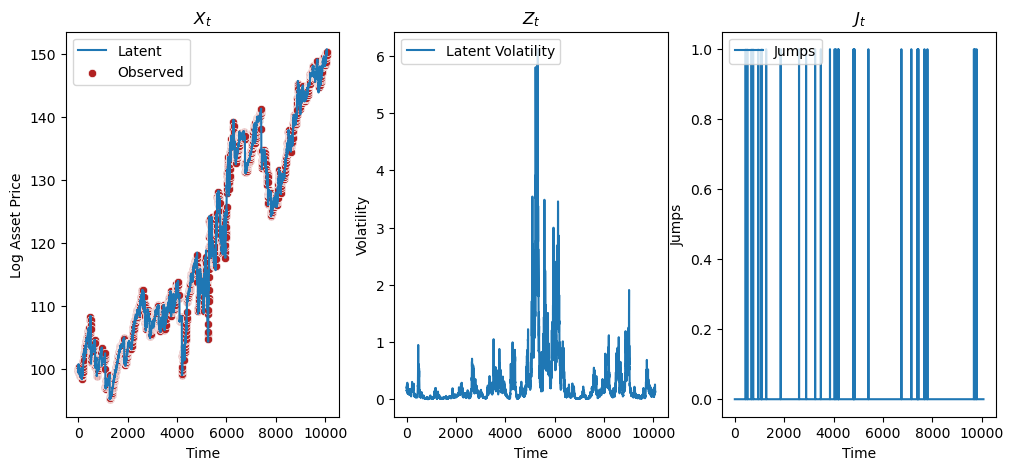

In [11]:
tmp = pd.DataFrame(jnp.array([
    jnp.arange(y_meas_reparam.shape[0]) * my_n_res,
    y_meas_reparam
]).T, columns = ["Time", "Log Asset Price"])

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 5), sharey = False)

sns.lineplot(data= x_state_reparam[:,:,1].reshape(my_n_res*my_n_obs,1)[(my_n_res-1):].squeeze(),
             ax = ax[0],
             label = "Latent")
sns.scatterplot(x = "Time", y = "Log Asset Price", 
                data = tmp,
                color = "firebrick",
                ax = ax[0],
                label="Observed").set(title ="$X_t$");

sns.lineplot(data= jnp.exp(x_state_reparam[:,:,0].reshape(my_n_res*my_n_obs,1)[(my_n_res-1):].squeeze()),
             ax = ax[1],
             label = "Latent Volatility").set(xlabel="Time",title = "$Z_t$", ylabel="Volatility");

sns.move_legend(ax[1], "upper left")

sns.lineplot(data= x_state_reparam[:,:,-1].reshape(my_n_res*my_n_obs,1)[(my_n_res-1):].squeeze(),
             ax = ax[2],
             label = "Jumps").set(xlabel="Time",title = "$J_t$", ylabel="Jumps");
sns.move_legend(ax[2], "upper left")

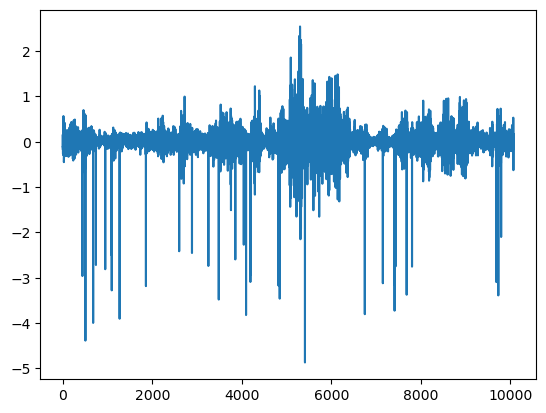

In [12]:
plt.plot(jnp.diff(x_state_reparam[:,:,1].reshape(my_n_res*my_n_obs,1)[(my_n_res-1):].squeeze()))

In [237]:
import jax.tree_util as jtu
import jax.flatten_util as jfu

def logw_to_prob(logw):
    r"""
    Calculate normalized probabilities from unnormalized log weights.

    Args:
        logw: Vector of `n_particles` unnormalized log-weights.

    Returns:
        Vector of `n_particles` normalized weights that sum to 1.
    """
    wgt = jnp.exp(logw - jnp.max(logw))
    prob = wgt / jnp.sum(wgt)
    return prob


def tree_array2d(x, shape0=None):
    r"""
    Convert a PyTree into a 2D JAX array.

    Starts by converting each leaf array to a 2D JAX array with same leading dimension.  Then concatenates these arrays along `axis=1`.  Assumes the leading dimension of each leaf is the same.

    **Notes:**

    - This function returns a tuple containing a Callable, so can't be jitted directly.  Can however be called in jitted code so long as the output is a PyTree.

    Args:
        x: A Pytree.
        shape0: Optional value of the leading dimension.  If `None` is deduced from `x`.

    Returns:
        tuple:
        - **array2d** - A two dimensional JAX array.
        - **unravel_fn** - A Callable to reconstruct the original PyTree.
    """
    if shape0 is None:
        shape0 = jtu.tree_leaves(x)[0].shape[0]  # leading dimension
    y, _unravel_fn = jfu.ravel_pytree(x)
    y = jnp.reshape(y, (shape0, -1))
    def unravel_fn(array2d): return _unravel_fn(jnp.ravel(array2d))
    return y, unravel_fn


def resample_custom(key, x_particles_prev, logw):
    r"""
    Particle resampler with Multivariate Normal approximation.

    Args:
        key: PRNG key.
        x_particles_prev: An `ndarray` with leading dimension `n_particles` consisting of the particles from the previous time step.
        logw: Vector of corresponding `n_particles` unnormalized log-weights.

    Returns:
        A dictionary with elements:
            - `x_particles`: An `ndarray` with leading dimension `n_particles` consisting of the particles from the current time step.
            - `mvn_mean`: Vector of length `n_state = prod(x_particles.shape[1:])` representing the mean of the MVN.
            - `mvn_cov`: Matrix of size `n_state x n_state` representing the covariance matrix of the MVN.
    """
    prob = logw_to_prob(logw)
    
    n_particles = logw.shape[0]
    
    condition = jnp.sum(prob) > 0.
    
    particles_tmp = x_particles_prev[:,-1,0]
    prob_tmp = jnp.where(condition,
                         prob,
                         jnp.array([1./n_particles]*n_particles))
    
    vol_mean = jnp.average(particles_tmp, weights=prob_tmp)
    vol_var = jnp.average((particles_tmp - vol_mean)**2, 
                          weights=prob_tmp)
    
    vol_std = jnp.sqrt(jnp.where(vol_var > 0., vol_var, 1e-6)) 
    vol_samples = vol_mean + vol_std * random.normal(key, shape=(n_particles,))
    x_particles = x_particles_prev.at[:,-1,0].set(vol_samples)
    return {
        "x_particles": x_particles,
        "vol_mean": vol_mean,
        "vol_std": vol_std
    }


In [238]:
pf_mvn = pf.particle_filter(
            model=eoumodel_reparam,
            key=random.PRNGKey(0),
            y_meas=y_meas_reparam,
            theta=my_theta,
            n_particles=300,
            resampler=resample_custom,
            history=True
        )

In [239]:
pf_mvn['loglik']

DeviceArray(-1162.5671, dtype=float32)

In [91]:

def pf_mvn_objective(params):
    pf_mvn = pf.particle_filter(
            model=eoumodel_reparam,
            key=random.PRNGKey(0),
            y_meas=y_meas_reparam,
            theta=params,
            n_particles=100,
            resampler=resample_custom
        )
    
    negloglik = -pf_mvn["loglik"]
    return negloglik


In [878]:
alpha,theta,kappa,sigma,lmbda,mu_x,sigma_x,mu_z = my_theta
def pf_mvn_objective_full(params):
    alpha,theta,kappa,sigma,mu_x = params
    my_theta = jnp.array([alpha,theta,kappa,sigma,lmbda,mu_x,sigma_x,mu_z])
    pf_mvn = pf.particle_filter(
            model=eoumodel_reparam,
            key=random.PRNGKey(0),
            y_meas=y_meas_reparam,
            theta=my_theta,
            n_particles=300,
            resampler=resample_custom
        )
    
    negloglik = -pf_mvn["loglik"]
    return negloglik


In [249]:
alpha,theta,kappa,sigma,lmbda,mu_x,sigma_x,mu_z = my_theta
def pf_mvn_objective(theta):
    params = jnp.array([alpha,theta,kappa,sigma,lmbda,mu_x,sigma_x,mu_z,sigma_z])
    pf_mvn = pf.particle_filter(
            model=eoumodel_reparam,
            key=random.PRNGKey(0),
            y_meas=y_meas_reparam,
            theta=params,
            n_particles=300,
            resampler=resample_custom
        )
    
    negloglik = -pf_mvn["loglik"]
    return negloglik



In [250]:
xs = jnp.linspace(theta - 3., theta + 1., num=100)

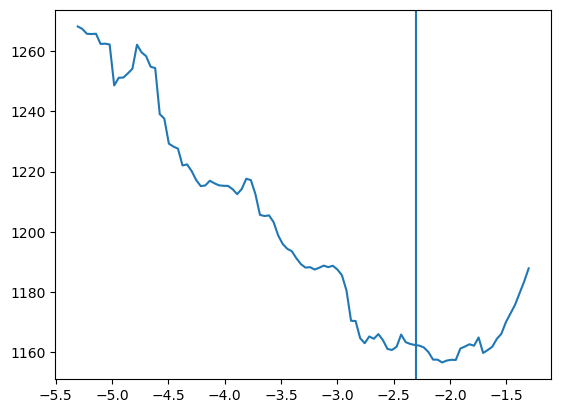

In [251]:
plt.plot(xs,jax.vmap(pf_mvn_objective)(xs))
plt.axvline(x=lmbda)

In [858]:
solver = jaxopt.GradientDescent(fun=pf_mvn_objective)
res = solver.run(jnp.array([alpha,theta,kappa,sigma]))

In [859]:
res

OptStep(params=DeviceArray([ 0.08680936, -1.5807046 , -3.0295212 , -1.1367768 ], dtype=float32), state=ProxGradState(iter_num=DeviceArray(500, dtype=int32, weak_type=True), stepsize=DeviceArray(0.00024414, dtype=float32, weak_type=True), error=DeviceArray(0.11121385, dtype=float32), aux=None, velocity=DeviceArray([ 0.08679288, -1.580781  , -3.0292218 , -1.1366563 ], dtype=float32), t=DeviceArray(252.37917, dtype=float32, weak_type=True)))

In [855]:
solver = jaxopt.GradientDescent(fun=pf_mvn_objective)
res = solver.run(alpha)

In [856]:
res

OptStep(params=DeviceArray(-1.4385874, dtype=float32), state=ProxGradState(iter_num=DeviceArray(5, dtype=int32, weak_type=True), stepsize=DeviceArray(0.5, dtype=float32, weak_type=True), error=DeviceArray(5.722046e-05, dtype=float32), aux=None, velocity=DeviceArray(-1.4389218, dtype=float32), t=DeviceArray(3.8326013, dtype=float32, weak_type=True)))

In [ ]:
solver = jaxopt.GradientDescent(fun=pf_mvn_objective_full)
res_full = solver.run(jnp.array([alpha,theta,kappa,sigma,mu_x]))

In [865]:
res_full

OptStep(params=DeviceArray([ 5.1481472e+01, -5.0498605e-02,  1.9226394e+00,
             -7.1136975e+00,  2.0098900e+01, -1.2039459e+00,
              6.8473411e-01], dtype=float32), state=ProxGradState(iter_num=DeviceArray(1, dtype=int32, weak_type=True), stepsize=DeviceArray(2., dtype=float32, weak_type=True), error=DeviceArray(nan, dtype=float32), aux=None, velocity=DeviceArray([ 5.1481472e+01, -5.0498605e-02,  1.9226394e+00,
             -7.1136975e+00,  2.0098900e+01, -1.2039459e+00,
              6.8473411e-01], dtype=float32), t=DeviceArray(1.618034, dtype=float32, weak_type=True)))

In [860]:
my_theta

DeviceArray([ 0.08     , -1.9      , -3.912023 , -1.2039728, -3.912023 ,
             -3.1      , -0.5108256, -1.7      , -3.912023 ],            dtype=float32)

In [20]:
from jaxopt import ScipyBoundedMinimize

lbfgsb = ScipyBoundedMinimize(fun=pf_mvn_objective)
lower_bounds = alpha-jnp.ones_like(alpha)
upper_bounds = alpha+jnp.ones_like(alpha)
bounds = (lower_bounds, upper_bounds)
lbfgsb_sol = lbfgsb.run(alpha, bounds=bounds)


In [454]:
pf_mvn_objective(alpha,theta,kappa,sigma,lmbda,mu_x,sigma_x,mu_z)

DeviceArray(13.692081, dtype=float32)

In [338]:
pf_mvn_objective(my_theta+.01*jnp.ones_like(my_theta))

DeviceArray(123.54288, dtype=float32)

In [273]:
jnp.isnan(test)

DeviceArray(True, dtype=bool)

In [204]:
eoumodel_reparam.get_theta(my_theta+2*jnp.ones_like(my_theta))

{'alpha': DeviceArray(2.08, dtype=float32),
 'theta': DeviceArray(1.5, dtype=float32),
 'kappa': DeviceArray(2.1, dtype=float32),
 'sigma_z': DeviceArray(0.8127962, dtype=float32),
 'lambda': DeviceArray(0.22167167, dtype=float32),
 'mu_x': DeviceArray(-1.0999999, dtype=float32),
 'sigma_x': DeviceArray(4.4334335, dtype=float32),
 'mu_z': DeviceArray(5.9112444, dtype=float32)}

In [280]:
maxiter = 2
solver = jaxopt.BFGS(fun=pf_mvn_objective, maxiter=maxiter)
res = solver.run(my_theta, key=my_key)


In [76]:
point_plot = pd.DataFrame(jnp.array([
    jnp.arange(y_meas_reparam.shape[0]) * my_n_res,
    y_meas_reparam
]).T, columns = ["Time", "Log Asset Price"])


def plot_particles (x_state, y_meas, vol_particles, price_particles, title=""):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 5), sharex = True)
    fig.suptitle(title)

    sns.lineplot(data= x_state[..., 1].reshape(my_n_res*my_n_obs, 1)[(my_n_res-1):].squeeze(),
                 ax = ax[0],
                 label = "Latent")
    
    sns.lineplot(data= x_state[..., 0].reshape(my_n_res*my_n_obs,1)[(my_n_res-1):].squeeze(),
                 ax = ax[1],
                 label = "Latent Volatility").set(xlabel="Time",title = "$Z_t$", ylabel="Volatility");
    
    
    for t in range(my_n_obs-1):
        for s in range(my_n_res):
            my_x = (t*my_n_res) + s
            sns.lineplot(x = my_x, 
                            y=price_particles[t, :, s], 
                            #s = 2, 
                            alpha = 0.3,
                            color = "green", ax = ax[0]);
            sns.lineplot(x = my_x, 
                            y=vol_particles[t, :, s], 
                            #s = 2, 
                            alpha = 0.3,
                            color = "green", ax = ax[1]);
            
    sns.scatterplot(x = "Time", y = "Log Asset Price", 
                    data = point_plot,
                    color = "firebrick",
                    ax = ax[0],
                    label="Observed").set(xlabel="Time",title ="$X_t$");


In [77]:
plot_particles(x_state_reparam, y_meas_reparam, 
               vol_particles=pf_mvn["x_particles"][1:, :, :, 0], 
               price_particles=pf_mvn["x_particles"][1:, :, :, 1],
               title = "MVN Resampling")

NameError: name 'pf_mvn' is not defined

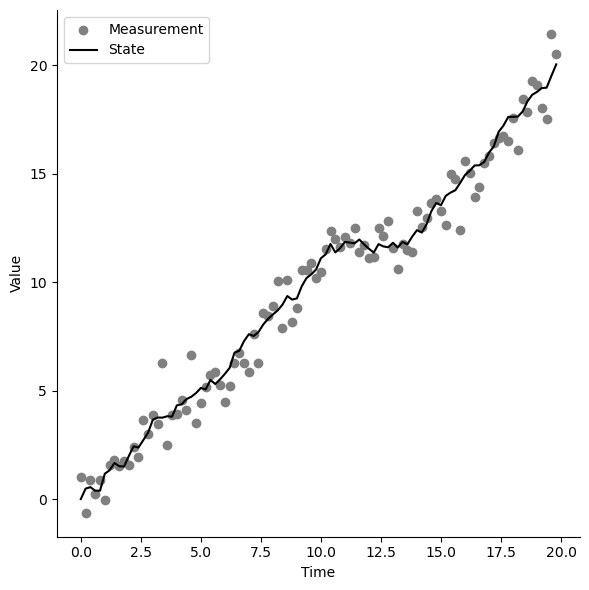

In [404]:
from pfjax.models import BMModel
# initial key for random numbers
key = random.PRNGKey(0)

# parameter values
mu, sigma, tau = 1., .5, .8
theta_true = jnp.array([mu, jnp.log(sigma), jnp.log(tau)])

# data specification
dt = .2
n_obs = 100
x_init = jnp.array([0.])

# simulate data
bm_model = BMModel(
    dt=dt, 
    unconstrained_theta=True # puts theta on the unconstrained scale
) 
key, subkey = random.split(key)
y_meas, x_state = pf.simulate(
    model=bm_model,
    key=subkey,
    n_obs=n_obs,
    x_init=x_init,
    theta=theta_true
)

# plot data
plot_df = (pd.DataFrame({"time": jnp.arange(n_obs) * dt,
                         "state": jnp.squeeze(x_state),
                         "meas": jnp.squeeze(y_meas)}))

g = sns.FacetGrid(plot_df, height = 6)
g = g.map(plt.scatter, "time", "meas", color="grey")
plt.plot(plot_df['time'], plot_df['state'], color='black')
plt.legend(labels=["Measurement","State"])
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

In [405]:
from pfjax.particle_resamplers import resample_mvn

In [406]:
bm_out = pf.particle_filter(
            model=bm_model,
            key=random.PRNGKey(123),
            y_meas=y_meas,
            theta=theta_true,
            n_particles=100,
            resampler=resample_mvn,
            history=True
        )


In [410]:
pf_mvn_objective(theta_true)

DeviceArray(141.43091, dtype=float32)

In [408]:
def pf_mvn_objective(params):
    bm_out = pf.particle_filter(
            model=bm_model,
            key=random.PRNGKey(123),
            y_meas=y_meas,
            theta=params,
            n_particles=100,
            resampler=resample_mvn
        )
    negloglik = -bm_out["loglik"]
    return negloglik

In [411]:
pf_mvn_grad = jax.grad(pf_mvn_objective)

In [434]:
solver = jaxopt.GradientDescent(fun=pf_mvn_objective, tol=1e-6)
res = solver.run(theta_true*1.1)

In [433]:
res

OptStep(params=DeviceArray([ 0.9399212 , -0.4955424 , -0.18451013], dtype=float32), state=ProxGradState(iter_num=DeviceArray(500, dtype=int32, weak_type=True), stepsize=DeviceArray(0.00390625, dtype=float32, weak_type=True), error=DeviceArray(0.01299369, dtype=float32), aux=None, velocity=DeviceArray([ 0.9399225 , -0.4955473 , -0.18457045], dtype=float32), t=DeviceArray(252.37917, dtype=float32, weak_type=True)))

In [440]:
jnp.exp(res.params[2])

DeviceArray(0.8314431, dtype=float32)

In [438]:
pf_mvn_grad(res.params)

DeviceArray([-4.8398972e-05, -2.7790666e-06,  5.6773424e-05], dtype=float32)

In [436]:
pf_mvn_objective(jnp.array([ 0.9399212 , -0.4955424 , -0.18451013]))

DeviceArray(138.82132, dtype=float32)

In [422]:
pf_mvn_objective(theta_true)

DeviceArray(139.6283, dtype=float32)

In [441]:
theta_true

DeviceArray([ 1.        , -0.6931472 , -0.22314353], dtype=float32)

In [431]:
theta_true*0.9

DeviceArray([ 0.9       , -0.62383246, -0.20082918], dtype=float32)

In [435]:
res

OptStep(params=DeviceArray([ 0.93992513, -0.49554735, -0.18459243], dtype=float32), state=ProxGradState(iter_num=DeviceArray(500, dtype=int32, weak_type=True), stepsize=DeviceArray(0.015625, dtype=float32, weak_type=True), error=DeviceArray(8.2252154e-05, dtype=float32), aux=None, velocity=DeviceArray([ 0.93992543, -0.4955473 , -0.1845942 ], dtype=float32), t=DeviceArray(252.37917, dtype=float32, weak_type=True)))

In [4]:
def g(x):
    return x
    
def dg(x):
    return jax.grad(g)(x)
    


In [5]:
xs = jnp.linspace(0.,1)

In [6]:
dg(1.**2)

DeviceArray(1., dtype=float64, weak_type=True)

In [245]:
jax.vmap(dg)(xs)

DeviceArray([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1.], dtype=float32)